In [1]:
#ch13_DecisionTree_01a.ipynb

In [2]:
sc.master

u'local[*]'

In [3]:
#1. 資料準備

In [4]:
#step1.1 sc.textFile() 讀取 train.tsv , 並命名為 rawDataWithHeader
rawDataWithHeader = sc.textFile("train.tsv")

In [5]:
type(rawDataWithHeader) #rawDataWithHeader 是一個 pyspark.rdd.RDD 物件

pyspark.rdd.RDD

In [6]:
#step1.2  以RDD.take() 檢視資料
rawDataWithHeader.take(2)

[u'"url"\t"urlid"\t"boilerplate"\t"alchemy_category"\t"alchemy_category_score"\t"avglinksize"\t"commonlinkratio_1"\t"commonlinkratio_2"\t"commonlinkratio_3"\t"commonlinkratio_4"\t"compression_ratio"\t"embed_ratio"\t"framebased"\t"frameTagRatio"\t"hasDomainLink"\t"html_ratio"\t"image_ratio"\t"is_news"\t"lengthyLinkDomain"\t"linkwordscore"\t"news_front_page"\t"non_markup_alphanum_characters"\t"numberOfLinks"\t"numwords_in_url"\t"parametrizedLinkRatio"\t"spelling_errors_ratio"\t"label"',
 u'"http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html"\t"4042"\t"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the

In [7]:
#step1.3 資料處理
#第一筆資料是欄位名稱，不需要
#以 ‘\t’分隔欄位,每個欄位間皆有雙引號「”」區隔
#無資料欄位以「?」表示

#step1.3.1 移除第一筆資料(欄位名稱)
header = rawDataWithHeader.first() 
rawData = rawDataWithHeader.filter(lambda x:x !=header)

#step1.3.2 以replace(), 將「”」換成空字串''
rData=rawData.map(lambda x: x.replace("\"", ""))    

#step1.3.3 以split(),依 \t 將字串分開, split() 回傳是list
lines = rData.map(lambda x: x.split("\t"))

In [8]:
lines.count() #共7395

7395

In [9]:
#setp1.4 檢視lines第一筆資料,忽略欄位0~2 
lines.first()[3:]

[u'business',
 u'0.789131',
 u'2.055555556',
 u'0.676470588',
 u'0.205882353',
 u'0.047058824',
 u'0.023529412',
 u'0.443783175',
 u'0',
 u'0',
 u'0.09077381',
 u'0',
 u'0.245831182',
 u'0.003883495',
 u'1',
 u'1',
 u'24',
 u'0',
 u'5424',
 u'170',
 u'8',
 u'0.152941176',
 u'0.079129575',
 u'0']

In [10]:
#2. 擷取feature欄位 (分類特徵欄位擷取, 數值特徵欄位擷取)
# 2a.   分類特徵(category feature)--> 欄位3, 'alchemy_category'(網頁分類)
#         在分類演算法(二元或多元)中, category feature 並無法直接使用, 需得轉換為數值欄位才能運作
#         Spark 提供 OneHotEncoder 模組,協助實作上述轉換
#2b.   數值特徵(numeric feature) --> 欄位4~25
#2c.  回傳「分類特徵欄位」+「數字特徵欄位」

In [11]:
#step2a.1 建立dict categoriesMap, 將'alchrmy_category' 文字內容先歸類並給定數值索引,做成對照表(字典形式)
categoriesMap =lines.map(lambda fields: fields[3]) \
        .distinct().zipWithIndex().collectAsMap()

In [12]:
categoriesMap #檢視 dict categoriesMap 內容

{u'?': 12,
 u'arts_entertainment': 13,
 u'business': 2,
 u'computer_internet': 3,
 u'culture_politics': 5,
 u'gaming': 0,
 u'health': 11,
 u'law_crime': 7,
 u'recreation': 1,
 u'religion': 9,
 u'science_technology': 6,
 u'sports': 8,
 u'unknown': 4,
 u'weather': 10}

In [13]:
len(categoriesMap) 

14

In [14]:
type(categoriesMap)

dict

In [15]:
#step2.2 建立extract_feature() function
import numpy as np
def extract_features(field,categoriesMap,featureEnd):
    #2.2a 擷取分類特徵欄位
    categoryIdx = categoriesMap[field[3]] 
    categoryFeatures = np.zeros(len(categoriesMap))
    categoryFeatures[categoryIdx] = 1
    #2.2b 擷取數值欄位
    numericalFeatures=[convert_float(field)  for  field in field[4: featureEnd]]    
    #2.2c 回傳「分類特徵欄位」+「數字特徵欄位」
    return  np.concatenate(( categoryFeatures, numericalFeatures))

def convert_float(x):
    return (0 if x=="?" else float(x))

In [16]:
#step2.3 擷取 label 欄位, field[-1]
def extract_label(field):
    label=(field[-1])
    return float(label)

In [17]:
#step2.4 建立訓練評估所需資料, LabeledPoint 格式(由 label與feature組成)
#step2.4a                
labelRDD = lines.map( lambda r: extract_label(r))
print labelRDD.take(1)

[0.0]


In [18]:
#step2.4 建立訓練評估所需資料, LabeledPoint 格式(由 label與feature組成)
#              使用先前建立的函數,extract_label(), extract_teatures() 與 LabeledPoint module
from pyspark.mllib.regression import LabeledPoint  #import LabeledPoint module
labelpointRDD = lines.map( lambda r:                          #labelPointRDD
     LabeledPoint(
                extract_label(r),
                extract_features(r,categoriesMap,len(r) - 1)))

In [19]:
#step2.4.1 檢視未轉換處理前資料 lines, 'alchemy_category'--> 'business'
print lines.first()[3:]

[u'business', u'0.789131', u'2.055555556', u'0.676470588', u'0.205882353', u'0.047058824', u'0.023529412', u'0.443783175', u'0', u'0', u'0.09077381', u'0', u'0.245831182', u'0.003883495', u'1', u'1', u'24', u'0', u'5424', u'170', u'8', u'0.152941176', u'0.079129575', u'0']


In [20]:
#step2.4.2 檢視轉換處理後資料 labelpointRDD, 這是訓練評估可接受的 LabeledPoint 格式
#                  第一個欄位為 label=0.0,第二個欄位是組裝的特徵向量, 注意特徵向量的前14個值:
#                  0.0,0.0,   1.0,    0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0   ,這是由 'alchemy_category'='business'  經
#                  categroyMap 對應索引為 2 (第三個位置 1.0) , 這裡 categoryMap N=14
labelpointRDD.take(1)

[LabeledPoint(0.0, [0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789131,2.055555556,0.676470588,0.205882353,0.047058824,0.023529412,0.443783175,0.0,0.0,0.09077381,0.0,0.245831182,0.003883495,1.0,1.0,24.0,0.0,5424.0,170.0,8.0,0.152941176,0.079129575])]

In [21]:
#step3 以隨機方式(但分配比例)將資料分成 訓練資料 (trainData)(8), 驗證資料 (validationDate)(1), 測試資料 (testData)(1)
#           使用 RDD.randomSplit() 
#           這裡的測試資料(testData)及驗證資料(validationData), 我們將在 評估,驗證訓練(validation train) 及 交叉驗證 (cross validation train) 時使用
#           在step6 評估時 使用 validateionData
( trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])

In [22]:
#step3.1 檢視分配後資料筆數
print("將資料分trainData:" + str(trainData.count()) +   
          "   validationData:" + str(validationData.count()) + 
          "   testData:" + str(testData.count()))

將資料分trainData:5912   validationData:776   testData:707


In [23]:
#step4 為了後續步驟,我們將前面資料處理的指令寫成一個函數 PrepareData(sc)
def PrepareData(sc):
    #------------1. 匯入並轉換資料----------------------------------------
    print("開始匯入資料...")
    rawDataWithHeader = sc.textFile("train.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共計：" + str(lines.count()) + "筆")
    #----------2.建立訓練評估所需資料 RDD[LabeledPoint]-------    
    categoriesMap = lines.map(lambda fields: fields[3]).\
                                   distinct().zipWithIndex().collectAsMap()
    labelpointRDD = lines.map( lambda r:
               LabeledPoint(
                      extract_label(r), 
                      extract_features(r,categoriesMap,-1)))
    
    labelpointRDDFeaturesInfo = lines.map( lambda r:LabeledPoint(
                 extract_label(r), 
                 extract_features_FeaturesInfo(r,categoriesMap,len(r) - 1)))
        
    #-----------3.以隨機方式將資料分為3部份並且回傳-------------
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print("將資料分trainData:" + str(trainData.count()) + 
              "   validationData:" + str(validationData.count()) +
              "   testData:" + str(testData.count()))
    return (trainData, validationData, testData, categoriesMap) #回傳資料

In [24]:
#step4.1 執行 PrepareData(sc) function
(trainData, validationData, testData, categoriesMap) =PrepareData(sc)

開始匯入資料...
共計：7395筆
將資料分trainData:5881   validationData:749   testData:765


In [25]:
#step4.2 以RDD.persist() 將資料暫存在MM中
trainData.persist()
validationData.persist()
testData.persist()

PythonRDD[31] at RDD at PythonRDD.scala:48

In [26]:
#step5. 訓練模型
#          前面, 我們已建立訓練所需資料格式 LabeledPoint, 並建立訓練資料 trainData
#          這裡, 我們將以Decision Tree Algorithm 訓練後建立Model (DecisionTree Model)

In [27]:
#step5.1 匯入 DecisionTree module
from pyspark.mllib.tree import DecisionTree

In [28]:
#step5.2 以DecisionTree.trainClassifier(), 訓練資料 trainData 
#              numClasser=2 (label 分類數為 2), 
#              參數categoricalFeaturesInfo,這其實是一個字典如果沒有分類型特徵，categoricalFeaturesInfo= {}
#              訓練參數設定: impurity="entropy", maxDepth=5, maxBins=5
#              訓練結果為 DecisionTree 'model'
model=DecisionTree.trainClassifier( \
        trainData, numClasses=2, categoricalFeaturesInfo={}, \
        impurity="entropy", maxDepth=5, maxBins=5)

In [29]:
#檢視 model (decision tree)
print model.toDebugString()

DecisionTreeModel classifier of depth 5 with 61 nodes
  If (feature 31 <= 2689.0)
   If (feature 31 <= 1197.0)
    If (feature 11 <= 0.0)
     If (feature 23 <= 0.038427167)
      If (feature 16 <= 0.642458101)
       Predict: 0.0
      Else (feature 16 > 0.642458101)
       Predict: 1.0
     Else (feature 23 > 0.038427167)
      If (feature 13 <= 0.0)
       Predict: 0.0
      Else (feature 13 > 0.0)
       Predict: 0.0
    Else (feature 11 > 0.0)
     If (feature 20 <= 0.627659574)
      If (feature 17 <= 0.16519174)
       Predict: 1.0
      Else (feature 17 > 0.16519174)
       Predict: 1.0
     Else (feature 20 > 0.627659574)
      If (feature 33 <= 7.0)
       Predict: 0.0
      Else (feature 33 > 7.0)
       Predict: 1.0
   Else (feature 31 > 1197.0)
    If (feature 1 <= 0.0)
     If (feature 2 <= 0.0)
      If (feature 11 <= 0.0)
       Predict: 0.0
      Else (feature 11 > 0.0)
       Predict: 1.0
     Else (feature 2 > 0.0)
      If (feature 35 <= 0.119266055)
       Predict:

In [30]:
#step6. 使用模型進行預測
#前面, 我們已由訓練建立DecisionTree Model
#這裡, 我們將以此Model 預測 test.tsv 資料, test.tsv 只萃取 feature field

In [31]:
#step6.1 定義 PredictData() function
def PredictData(sc,model,categoriesMap): 
    print("開始匯入資料...")
    
    #讀取資料與萃取feature欄位
    rawDataWithHeader = sc.textFile("test.tsv")  #以sc.textFile() 讀取 "test.tsv"
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共計：" + str(lines.count()) + "筆")
    
    #建立dataRDD, 網頁網址與feature欄位組成 
    dataRDD = lines.map(lambda r:  ( r[0]  ,
                            extract_features(r,categoriesMap,len(r) )))
    #建立一個轉換字典,用以轉換顯示
    DescDict = {
           0: "暫時性網頁(ephemeral)",
           1: "長青網頁(evergreen)"
     }
    #顯示預測結果的前 10 筆,使用model.predict() 
    for data in dataRDD.take(10):
        predictResult = model.predict(data[1])  #data[1] -->feature欄位
        print " 網址：  " +str(data[0])+"\n" +\
                  "             ==>預測:"+ str(predictResult)+ \
                  " 說明:"+DescDict[predictResult] +"\n"    

In [32]:
#step6.2 叫用 PredictData() 進行預測
PredictData(sc, model, categoriesMap)

開始匯入資料...
共計：3171筆
 網址：  http://www.lynnskitchenadventures.com/2009/04/homemade-enchilada-sauce.html
             ==>預測:1.0 說明:長青網頁(evergreen)

 網址：  http://lolpics.se/18552-stun-grenade-ar
             ==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.xcelerationfitness.com/treadmills.html
             ==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.bloomberg.com/news/2012-02-06/syria-s-assad-deploys-tactics-of-father-to-crush-revolt-threatening-reign.html
             ==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.wired.com/gadgetlab/2011/12/stem-turns-lemons-and-limes-into-juicy-atomizers/
             ==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.latimes.com/health/boostershots/la-heb-fat-tax-denmark-20111013,0,2603132.story
             ==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.howlifeworks.com/a/a?AG_ID=1186&cid=7340ci
             ==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://romancingthestoveblog.wordpress.com/2010/01/13/sweet-potato-ravioli-with-lemon-sage-brown-butter-sa

In [ ]:
#step7.  評估模型準確率
#            二元分類演算法,我們以AUC (Area under the Curve of ROC) 來評估
#            Spark Mllib 提供 BinaryClassificationMetrics 模組, 我們用它來計算AUC

In [30]:
#step7.1 使用 pyspark.mllib.tree.DecisionTreeModel.predict()
#             參數是之前(step3) 的那一份 validationData 的 features 部份
#             我們拿 validationData 的features 來作預測, 結果是score
score = model.predict(validationData.map(lambda p: p.features)) 

In [32]:
score.take(5) #score 是我們以我們訓練出的 DesisionTreeModel 'model', 參數是之前(step3) 的那一份 validationData 的 features 部份
                       #的預測值

[1.0, 0.0, 1.0, 1.0, 0.0]

In [33]:
#step7.2  以zip() 作迭代, 結合 score 與 validateionData.lable 成為 scoreAndLables
scoreAndLabels=score .zip(validationData.map(lambda p: p.label)) #p.label--> validationData 的label部份
scoreAndLabels.take(5) #顯示前5筆

[(1.0, 0.0), (0.0, 0.0), (1.0, 1.0), (1.0, 0.0), (0.0, 0.0)]

In [35]:
#step7.3 以BinaryClassificationMetrics 計算 AUC
# 匯入 BinaryClassificationMetrics module
from pyspark.mllib.evaluation import BinaryClassificationMetrics
# 以BinaryClassificationMetrics(), 參數 scoreAndLabels 計算,結果 'metrics' 
metrics= BinaryClassificationMetrics(scoreAndLabels)
#display AUC
print "AUC="+str(metrics.areaUnderROC)

AUC=0.645226112459


In [36]:
#step7.4  將上述步驟(step7.1~step7.3) 建成函數 evaluateModel()
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return( AUC)

In [37]:
#step7.5 使用函數 evaluateModel() 作評估
AUC=evaluateModel(model, validationData)
print "AUC="+str(AUC)

AUC=0.645226112459


In [ ]:
#step8. 模型的訓練參數及準確率
#在訓練模型時,輸入不同的參數,評估得到的模型準確率
#Decision Tree Model主要參數為: impurity, maxDepth, maxBins
#我們改變單一參數值作訓練後評估檢視準確率 

In [38]:
#step8.1 建立 trainEvaluateModel() 函數
from time import time
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print    "訓練評估：使用參數" + \
                " impurity="+str(impurityParm) +\
                " maxDepth="+str(maxDepthParm) + \
                " maxBins="+str(maxBinsParm) +"\n" +\
                 " ==>所需時間="+str(duration) + \
                 " 結果AUC = " + str(AUC) 
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)

In [39]:
#step8.2 使用 trainEvaluateModel(), inpurity='entropy', maxDepth=5, maxBins=5
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)

訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=2.19230699539 結果AUC = 0.645226112459


In [ ]:
#step8.3 使用 trainEvaluateModel() 評估 impurity 參數
#              impurityList=['gini','entropy'], maxDepthList 及 maxBinsList 都先固定為 [10] 

In [40]:
impurityList=["gini", "entropy"]
maxDepthList  =[10]
maxBinsList=[10 ]

metrics = [trainEvaluateModel(trainData, validationData,   #list comprehension
                              impurity,maxDepth,  maxBins  ) 
                 for impurity in impurityList 
                 for maxDepth in maxDepthList  
                 for maxBins in maxBinsList ]

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.87513208389 結果AUC = 0.617904341214
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=1.31812691689 結果AUC = 0.63357471306


In [41]:
metrics #檢視metrics

[(0.6179043412143814,
  1.8751320838928223,
  'gini',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 769 nodes),
 (0.6335747130598501,
  1.318126916885376,
  'entropy',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 655 nodes)]

In [42]:
#step8.3.1 將訓練評估結果以圖表顯示
import pandas as pd        #import pandas
IndexList=impurityList
#以pd.DataFrame() 建立 pandas DataFrame df
df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])

In [43]:
#step8.3.2 檢視 pandas DataFrame 'df'
df

,AUC,duration,impurity,maxDepth,maxBins,model
gini,0.617904,1.875132,gini,10,10,DecisionTreeModel classifier of depth 10 with ...
entropy,0.633575,1.318127,entropy,10,10,DecisionTreeModel classifier of depth 10 with ...


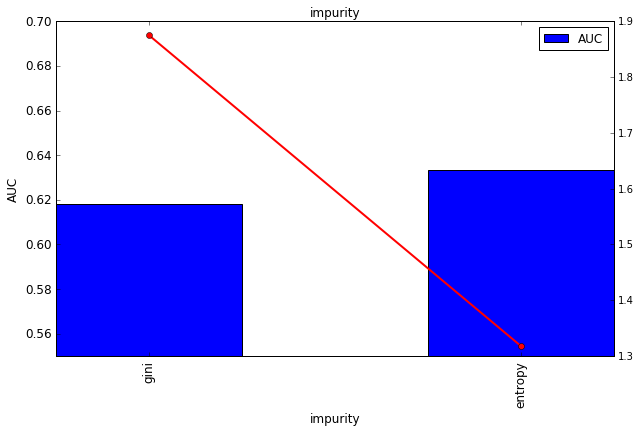

In [44]:
#step8.3.3 繪圖
import matplotlib.pyplot as plt  #匯入 matplotlib.pyplot module
#執行 magic command %matplotlib inline
%matplotlib inline                       
#設定繪圖參數
evalparm='impurity'
ax = df['AUC'].plot(kind='bar', title =evalparm,figsize=(10,6),
                legend=True, fontsize=12)
ax.set_xlabel(evalparm,fontsize=12)
ax.set_ylim([0.55,0.7])
ax.set_ylabel("AUC",fontsize=12)
ax2 = ax.twinx()
ax2.plot(df['duration'].values, linestyle='-', marker='o', linewidth=2.0,color='r')
#繪圖
plt.show()

In [45]:
#step8.3.4 將 step8.3.3 繪圖指令寫成函數 showchart() 
import matplotlib.pyplot as plt
def showchart(df,evalparm ,barData,lineData,yMin,yMax):
    ax = df[barData].plot(kind='bar', title =evalparm,
                                         figsize=(10,6),legend=True, fontsize=12)
    ax.set_xlabel(evalparm,fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData,fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData ].values, linestyle='-', marker='o',
                    linewidth=2.0,color='r')
    plt.show()

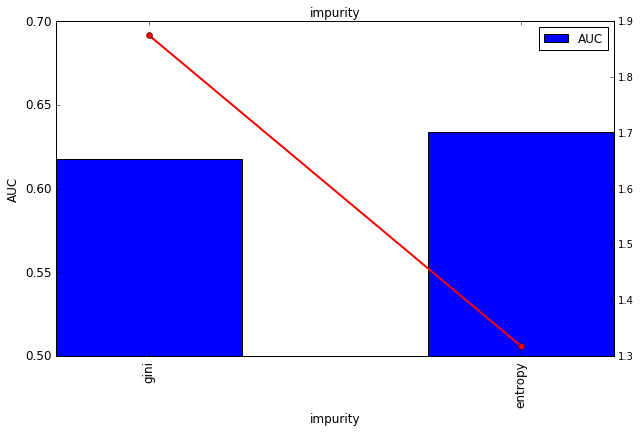

In [46]:
#step8.3.5 叫用 showchar() 繪圖
showchart(df,'impurity','AUC','duration',0.5,0.7 )

In [47]:
#step8.4 評估其他參數(maxDepth, maxBins)

In [48]:
#step8.4.1 定義evalParameter函數
def evalParameter(trainData, validationData, evalparm,
                  impurityList, maxDepthList, maxBinsList):
    #訓練評估參數
    metrics = [trainEvaluateModel(trainData, validationData,  
                                impurity,maxDepth,  maxBins  ) 
                       for impurity in impurityList
                       for maxDepth in maxDepthList  
                       for maxBins in maxBinsList ]
    #設定目前評估的參數
    if evalparm=="impurity":
        IndexList=impurityList[:]
    elif evalparm=="maxDepth":
        IndexList=maxDepthList[:]
    elif evalparm=="maxBins":
        IndexList=maxBinsList[:]
    #轉換為Pandas DataFrame
    df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
    #顯示圖形
    showchart(df,evalparm,'AUC','duration',0.5,0.7 )    

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.31219100952 結果AUC = 0.617904341214
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=1.13624596596 結果AUC = 0.63357471306


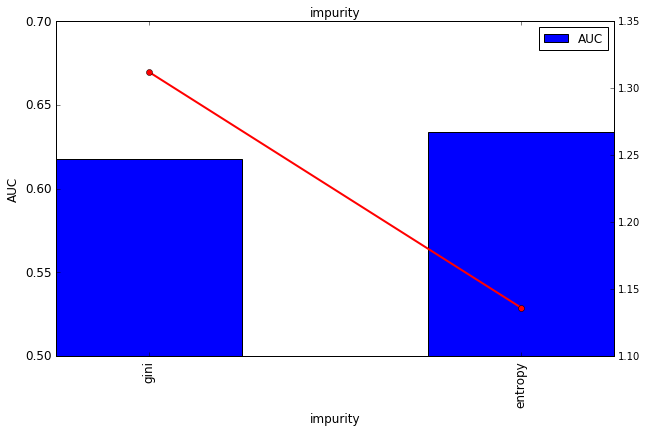

In [49]:
#step8.4.2 以evalParameter() 評估參數, 'impurity'
evalParameter(trainData, validationData,"impurity", 
                              impurityList=["gini", "entropy"],   
                              maxDepthList=[10],  
                              maxBinsList=[10 ])  

訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=0.904274940491 結果AUC = 0.606777942721
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=0.825474023819 結果AUC = 0.615540026793
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.02506804466 結果AUC = 0.617904341214
訓練評估：使用參數 impurity=gini maxDepth=15 maxBins=10
 ==>所需時間=1.69432687759 結果AUC = 0.584362214418
訓練評估：使用參數 impurity=gini maxDepth=20 maxBins=10
 ==>所需時間=2.12134218216 結果AUC = 0.572055469061
訓練評估：使用參數 impurity=gini maxDepth=25 maxBins=10
 ==>所需時間=2.38816690445 結果AUC = 0.576034613853


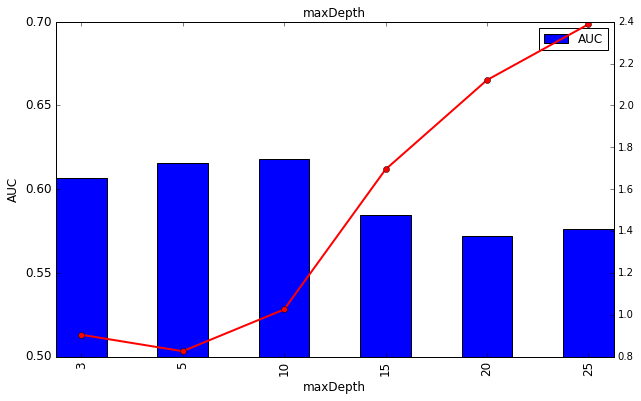

In [50]:
#step8.4.3 以evalParameter() 評估參數, 'maxDepth', impurity 固定為 'gini' 
evalParameter(trainData, validationData,"maxDepth", 
                          impurityList=["gini"],                    
                          maxDepthList=[3, 5, 10, 15, 20, 25],    
                          maxBinsList=[10])   

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=3
 ==>所需時間=1.17088103294 結果AUC = 0.630048155255
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=5
 ==>所需時間=1.02792310715 結果AUC = 0.620598138962
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=0.874217987061 結果AUC = 0.617904341214
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=50
 ==>所需時間=1.00392007828 結果AUC = 0.599594482059
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=100
 ==>所需時間=1.16874313354 結果AUC = 0.593783265144
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=200
 ==>所需時間=1.32457709312 結果AUC = 0.605898113617


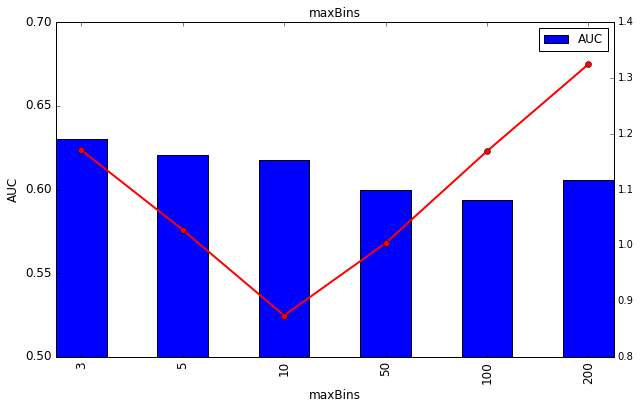

In [51]:
#step8.4.4 以evalParameter() 評估參數, 'maxBins', impurity 固定為 'gini' 
evalParameter(trainData, validationData,"maxBins", 
                          impurityList=["gini"],      
                          maxDepthList =[10],        
                          maxBinsList=[3, 5, 10, 50, 100, 200 ])

In [52]:
#step8.5 找出準確率最高的參數組合

In [53]:
#step8.5.1 定義evalAllParameter() 函數
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    
    #for迴圈訓練評估所有參數組合
    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    #找出AUC最大的參數組合, 使用sorted() function
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    #顯示調校後最佳參數組合      
    print("調校後最佳參數：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n,    結果AUC = " + str(bestParameter[0]))
    #傳回最佳模型
    return bestParameter[5]

In [54]:
    print("-----所有參數訓練評估找出最好的參數組合---------")  
    bestModel=evalAllParameter(trainData, validationData,
                          ["gini", "entropy"],
                          [3, 5, 10, 15, 20, 25], 
                          [3, 5, 10, 50, 100, 200 ])

-----所有參數訓練評估找出最好的參數組合---------
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=3
 ==>所需時間=0.968930959702 結果AUC = 0.590444983526
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=5
 ==>所需時間=0.72557091713 結果AUC = 0.610811397951
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=0.754012107849 結果AUC = 0.606777942721
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=50
 ==>所需時間=0.734247922897 結果AUC = 0.599065860458
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=100
 ==>所需時間=0.65847492218 結果AUC = 0.602060175966
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=200
 ==>所需時間=0.650671005249 結果AUC = 0.60334552301
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=3
 ==>所需時間=0.856428146362 結果AUC = 0.6161519244
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=5
 ==>所需時間=0.682247161865 結果AUC = 0.645226112459
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=0.670694112778 結果AUC = 0.615540026793
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=50
 ==>所需時間=0.70318198204 結果AUC = 0.607951048191
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=100

In [ ]:
#step8.6 檢視有無 Overfitting ?

In [55]:
AUC=evaluateModel(model, testData)
print "AUC="+str(AUC)

AUC=0.65284767316


In [ ]:
#與之前訓練接段AUC 差異不大, 代表沒有Overfitting 